In [ ]:
# ===== STEP 1: INSTALL REQUIRED PACKAGES =====
!pip install crewai==0.134.0
!pip install 'crewai[tools]'

In [ ]:
# ===== STEP 2: IMPORT LIBRARIES =====
import os
from crewai import Agent, Task, Crew, Process, LLM
from crewai_tools import SerperDevTool

import warnings
warnings.filterwarnings('ignore')

In [ ]:
# ===== STEP 3: SET UP API KEYS & LLMs=====
from google.colab import userdata

os.environ["GROQ_API_KEY"] = userdata.get('GROQ_API_KEY')
os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')
# os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

os.environ["SERPER_API_KEY"] = userdata.get('SERPER_API_KEY')

In [ ]:
from google.colab import userdata
gemini_api_key =  userdata.get('GEMINI_API_KEY')
print(gemini_api_key)

In [ ]:
# ===== Create LLMs
# groq_llm = LLM(
#     model="groq/llama-3.3-70b-versatile",
#     temperature=0.1
# )

gemini_llm = LLM(
    model="gemini/gemini-2.0-flash",
    api_key=gemini_api_key,
    # temperature=0.1
)

# openai_llm = LLM(
#     model="openai/gpt-4o-mini",
#     temperature=0.1
# )

In [ ]:
# ===== STEP 4: INITIALIZE TOOLS =====
search_tool = SerperDevTool()

In [ ]:
# ===== STEP 5: CREATE SPECIALIZED AGENTS =====

In [ ]:
# Agent 1: Question Research Expert
question_researcher = Agent(
    role='Interview Question Research Expert',
    goal='Find the most commonly asked and important interview questions for any given topic',
    backstory="""You are an expert recruiter and interview specialist with years of experience
    conducting technical interviews. You know exactly what questions are most frequently asked
    by top companies and can identify the most critical questions that candidates need to prepare for.
    You stay updated with the latest interview trends and have access to real interview experiences
    from various companies.""",
    tools=[],
    verbose=True,
    llm=gemini_llm
)

# Agent 2: DUBEXA Answer Expert
dubexa_expert = Agent(
    role='DUBEXA Format Answer Expert',
    goal='Create comprehensive, well-structured answers in DUBEXA format that help candidates thoroughly understand and explain concepts',
    backstory="""You are a master educator and technical communication expert who specializes
    in the DUBEXA format. You excel at breaking down complex concepts into clear, structured
    explanations that follow the DUBEXA methodology:

    - D: Definition using key technical terms
    - U: Use case scenarios and real-world examples
    - B: Benefits of using the concept
    - E: Example code (when applicable)
    - X: Extra information, edge cases, and limitations
    - A: Analogies and metaphors for better understanding

    You make technical concepts accessible while maintaining accuracy and depth.""",
    tools=[],
    verbose=True,
    llm=gemini_llm
)

# Agent 3: Interview Coach
interview_coach = Agent(
    role='Senior Interview Coach',
    goal='Provide additional interview tips, delivery advice, and presentation strategies for each answer',
    backstory="""You are a seasoned interview coach who has helped thousands of candidates
    succeed in their interviews. You understand not just what to say, but how to say it
    effectively. You provide practical tips on delivery, common follow-up questions,
    and strategies to make answers more impactful during actual interviews.""",
    tools=[],
    verbose=True,
    llm=gemini_llm
)

In [ ]:
# ===== STEP 6: DEFINE TASKS =====
def create_question_research_task(topic):
    return Task(
        description=f"""Research and identify the top 3 most commonly asked interview questions about {topic}.

        **Requirements:**
        1. Focus on questions that are frequently asked in technical interviews
        2. Prioritize questions that test fundamental understanding
        3. Include a mix of basic and intermediate level questions
        4. Ensure questions are relevant to current industry standards
        5. Look for questions from reputable sources like:
           - Top tech companies (Google, Amazon, Microsoft, etc.)
           - Popular interview preparation platforms
           - Technical forums and communities
           - Recent interview experiences shared online

        **Research Focus:**
        - Find actual interview questions, not generic study topics
        - Prioritize questions that require clear conceptual understanding
        - Look for questions that allow for DUBEXA format explanations
        - Consider questions that might have follow-ups or variations

        Topic: {topic}""",

        expected_output="""A list of exactly 3 interview questions about the topic, formatted as:

        **Question 1:** [Exact question text]
        **Source/Context:** [Where this question is commonly asked - company types, interview rounds, etc.]
        **Difficulty Level:** [Beginner/Intermediate/Advanced]

        **Question 2:** [Exact question text]
        **Source/Context:** [Where this question is commonly asked]
        **Difficulty Level:** [Beginner/Intermediate/Advanced]

        **Question 3:** [Exact question text]
        **Source/Context:** [Where this question is commonly asked]
        **Difficulty Level:** [Beginner/Intermediate/Advanced]

        Each question should be specific, commonly asked.""",

        agent=question_researcher
    )

def create_dubexa_answer_task(topic):
    return Task(
        description=f"""Create comprehensive DUBEXA format answers for each of the 3 interview questions about {topic}.

        **DUBEXA Format Requirements:**

        **D - Definition:**
        - Provide a clear, technically accurate definition
        - Use proper technical terminology
        - Keep it concise but complete

        **U - Use Cases & Why We Need It:**
        - Explain real-world scenarios where this is used
        - Provide specific, practical examples
        - Explain WHY this concept/technology is important
        - Include industry context

        **B - Benefits:**
        - List clear advantages and benefits
        - Compare with alternatives when relevant
        - Explain what problems it solves

        **E - Example Code:**
        - Provide practical, working code examples
        - Include comments explaining key parts
        - Use modern, best-practice syntax
        - Make examples relevant to the concept

        **X - Extra Information:**
        - Cover edge cases and limitations
        - Mention common pitfalls or misconceptions
        - Include performance considerations
        - Discuss when NOT to use it

        **A - Analogies & Metaphors:**
        - Create relatable analogies that simplify the concept
        - Use everyday examples that non-technical people could understand
        - Make the analogy memorable and accurate

        **Instructions:**
        - Answer each question thoroughly in DUBEXA format
        - Ensure answers are interview-appropriate (not too long, but comprehensive)
        - Use proper formatting and structure
        - Include all 6 DUBEXA components for each question""",

        expected_output="""Complete DUBEXA format answers for all 3 questions, structured as:

        ## Question 1: [Question text]

        **Definition:**
        [Clear technical definition]

        **Use Cases & Why We Need It:**
        [Real-world examples and importance]

        **Benefits:**
        [Advantages and problem-solving capabilities]

        **Example Code:**
        ```[language]
        [Working code example with comments]
        ```

        **Extra Information:**
        [Edge cases, limitations, best practices]

        **Analogies & Metaphors:**
        [Relatable analogies for better understanding]

        ---

        [Repeat same format for Questions 2 and 3]

        Each answer should be comprehensive yet concise enough for interview delivery.""",

        agent=dubexa_expert,
        context=[create_question_research_task(topic)]
    )

def create_interview_coaching_task(topic):
    return Task(
        description=f"""Provide interview coaching and delivery tips for the DUBEXA answers about {topic}.

        **Coaching Focus:**
        1. **Delivery Tips:** How to present each answer effectively
        2. **Time Management:** How long to spend on each part of DUBEXA
        3. **Follow-up Questions:** Anticipate likely follow-up questions
        4. **Common Mistakes:** What to avoid when answering
        5. **Confidence Building:** Tips to sound knowledgeable and prepared
        6. **Adaptation:** How to adjust answers based on interviewer's background

        **For Each Question Provide:**
        - Key points to emphasize during delivery
        - Suggested time allocation for each DUBEXA component
        - Potential follow-up questions interviewers might ask
        - Red flags or common mistakes to avoid
        - Tips for making the answer more engaging
        - How to gauge if the interviewer wants more or less detail""",

        expected_output="""Interview coaching guide with delivery tips for each question:

        ## Overall Interview Strategy for {topic}
        [General tips for approaching these types of questions]

        ## Question 1 Coaching: [Question text]
        **Delivery Tips:** [How to present this answer effectively]
        **Time Management:** [Suggested timing for each DUBEXA component]
        **Likely Follow-ups:** [Questions interviewer might ask next]
        **Common Pitfalls:** [What to avoid]
        **Engagement Tips:** [How to make answer more compelling]

        ## Question 2 Coaching: [Question text]
        [Same structure as above]

        ## Question 3 Coaching: [Question text]
        [Same structure as above]

        ## Final Interview Tips
        - Body language and confidence tips
        - How to handle if you don't know something
        - Ways to show enthusiasm and deeper knowledge
        - How to connect answers to real experience""",

        agent=interview_coach,
        context=[create_question_research_task(topic), create_dubexa_answer_task(topic)]
    )

In [ ]:
# ===== STEP 7: CREATE THE CREW =====
def create_interview_prep_crew(topic):
    """Create an interview preparation crew for a specific topic"""

    # Create all tasks for this topic
    research_task = create_question_research_task(topic)
    dubexa_task = create_dubexa_answer_task(topic)
    coaching_task = create_interview_coaching_task(topic)

    # Create the crew
    crew = Crew(
        agents=[question_researcher, dubexa_expert, interview_coach],
        tasks=[research_task, dubexa_task, coaching_task],
        process=Process.sequential,
        verbose=True,
        max_rpm=3
    )

    return crew

In [ ]:
# ===== STEP 8: EXAMPLE USAGE =====

# Example topic
example_topic = "JavaScript Closures"
interview_crew = create_interview_prep_crew(example_topic)
result = interview_crew.kickoff()

## With free models/providers you may encounter rate limits:

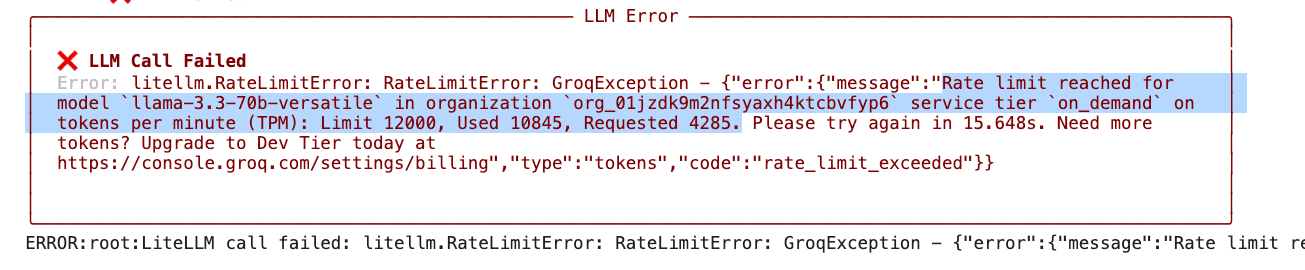

set `max_rpm` while assembling the crew